In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from wordcloud import WordCloud

In [3]:
import joblib

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
from sklearn.metrics import confusion_matrix, accuracy_score

# Carga del modelo

In [5]:
vectorizer = joblib.load("./modelo_svc/vectorizador_tfidf.pkl")

In [6]:
best_model = joblib.load("./modelo_svc/modelo_svc.pkl")

# Análisis Exploratorio de Datos

In [7]:
df = pd.read_csv("./dataset/BBC_Noticias.csv")

In [8]:
examples = df["Texto"]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Titulo          25 non-null     object
 1   Texto           25 non-null     object
 2   Etiquetas       25 non-null     object
 3   Contribuyentes  25 non-null     object
 4   URL             25 non-null     object
dtypes: object(5)
memory usage: 1.1+ KB


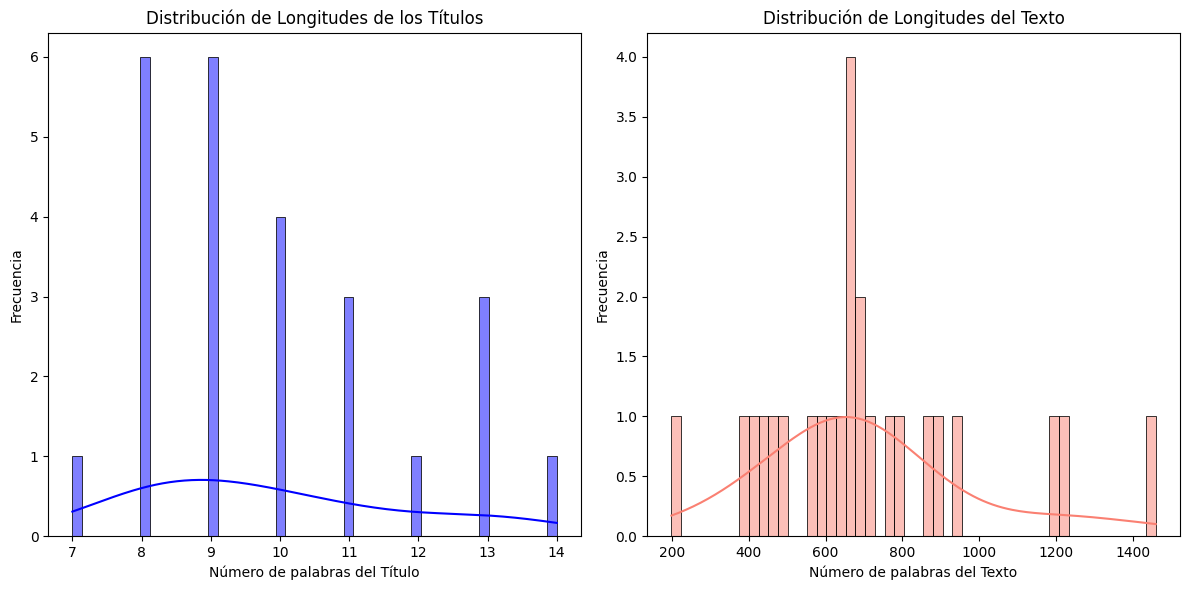

In [51]:
df['Longitud_Titulo'] = df['Titulo'].apply(lambda x: len(x.split()))
df['Longitud_Texto'] = df['Texto'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Longitud_Titulo'], kde=True, bins=50, color="blue")
plt.title('Distribución de Longitudes de los Títulos')
plt.xlabel('Número de palabras del Título')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(df['Longitud_Texto'], kde=True, bins=50, color="salmon")
plt.title('Distribución de Longitudes del Texto')
plt.xlabel('Número de palabras del Texto')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [11]:
df.describe()

,Longitud_Titulo,Longitud_Texto
count,25.000000,25.000000
mean,9.880000,708.280000
std,1.921805,279.272048
min,7.000000,199.000000
25%,8.000000,575.000000
50%,9.000000,672.000000
75%,11.000000,795.000000
max,14.000000,1459.000000


In [12]:
df['Etiquetas'] = df['Etiquetas'].str.split(', ')

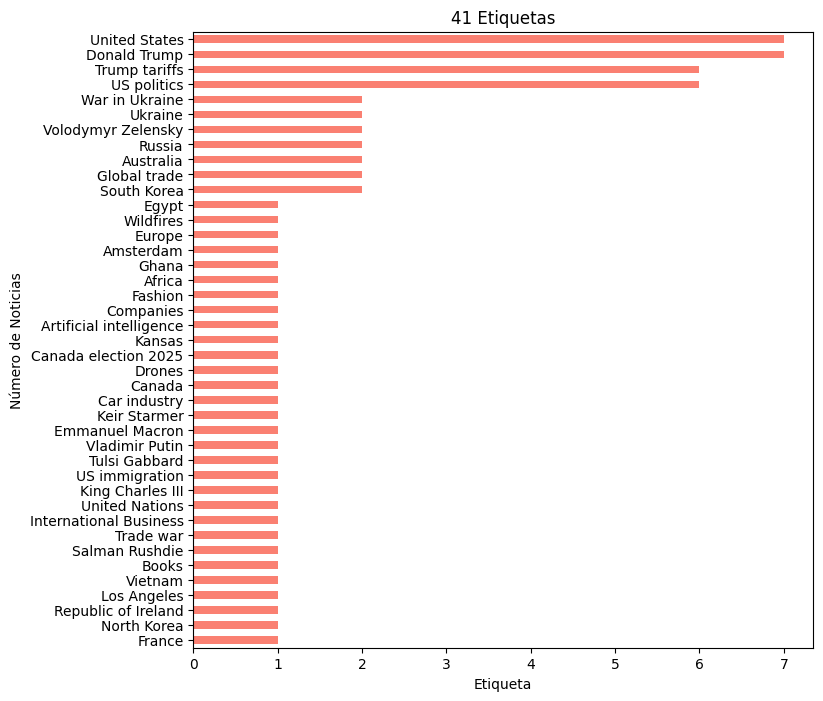

In [13]:
etiquetas_count = df['Etiquetas'].explode().value_counts().sort_values()
etiquetas_count.plot(kind='barh', figsize=(8, 8), color='salmon')
plt.title(f"{len(etiquetas_count)} Etiquetas")
plt.xlabel('Etiqueta')
plt.ylabel('Número de Noticias')
plt.show()

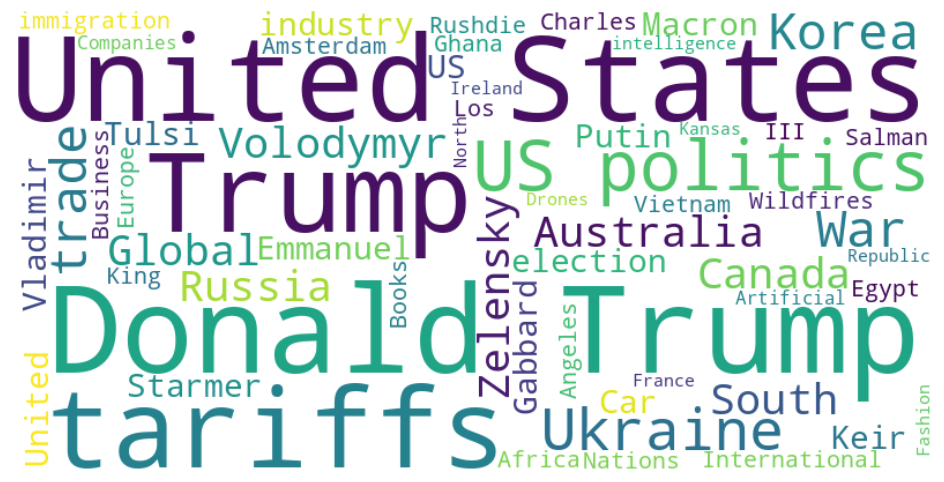

In [14]:
etiquetas_texto = " ".join(df['Etiquetas'].explode())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(etiquetas_texto)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [15]:
df['Contribuyentes'] = df['Contribuyentes'].str.split(r'[,&]|\band\b')

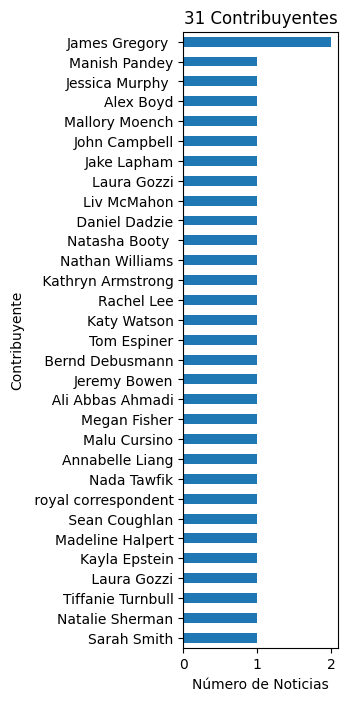

In [48]:
contribuyentes_count = df['Contribuyentes'].explode().value_counts().sort_values()
contribuyentes_count.plot(kind='barh', figsize=(2, 8))
plt.title(f"{len(contribuyentes_count)} Contribuyentes")
plt.xlabel('Número de Noticias')
plt.ylabel('Contribuyente')
plt.show()

# Simulitud Coseno

In [17]:
X = vectorizer.transform(examples).toarray()

In [18]:
cosine_sim = cosine_similarity(X)

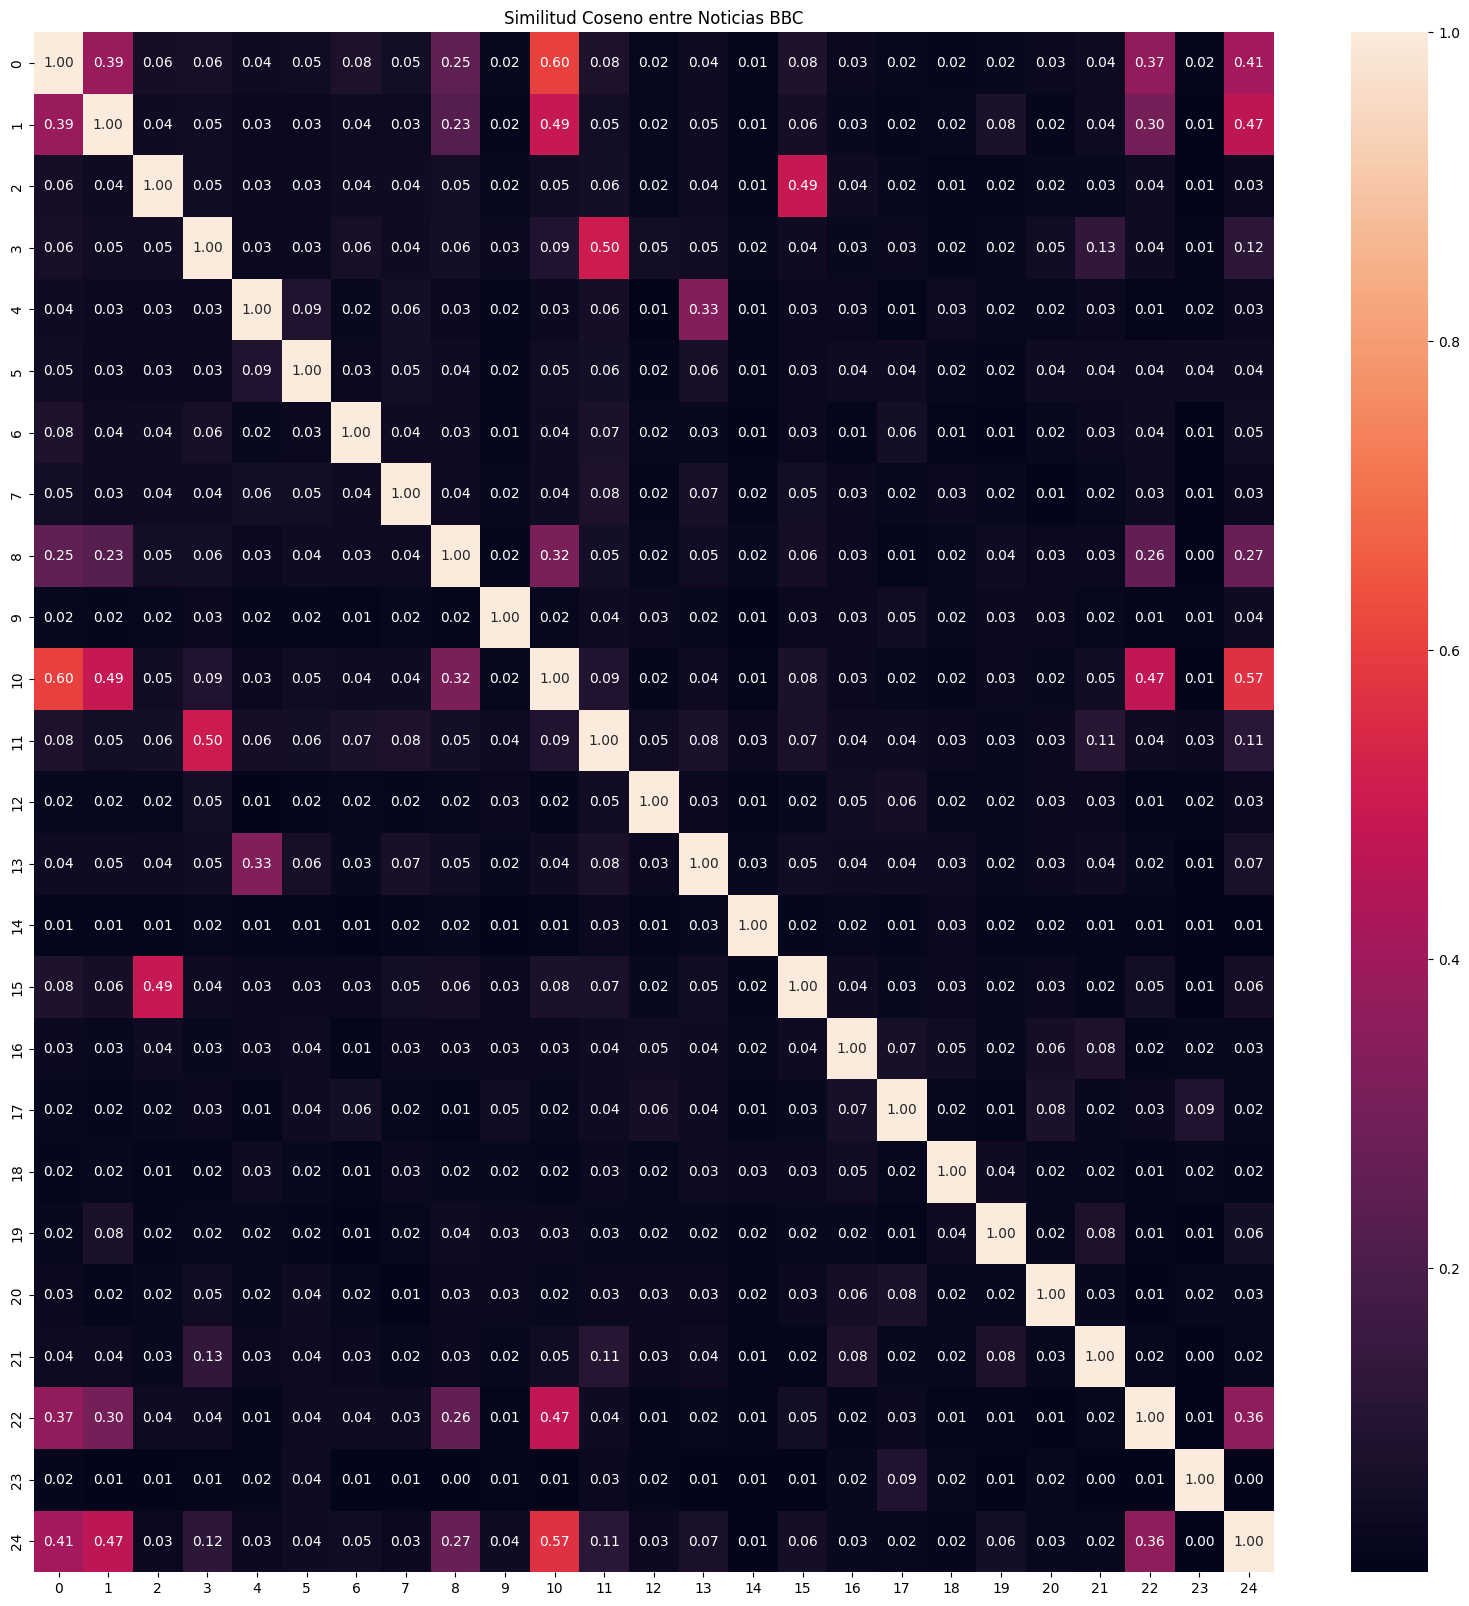

In [19]:
plt.figure(figsize=(20, 20))
sns.heatmap(cosine_sim, annot=True, fmt=".2f")
plt.title("Similitud Coseno entre Noticias BBC")
plt.show()

In [20]:
n = 40
for i, sim_row in enumerate(cosine_sim):
    j = np.argsort(sim_row)[-2] # exlcluye a sí mismo
    print(f"Similitud coseno: {sim_row[j]:.4f}")
    print(f"'{df.iloc[i]['Titulo'][:n]}...' es más similar a '{df.iloc[j]['Titulo'][:n]}...' \n")

Similitud coseno: 0.6024
'Canada PM Mark Carney says old relations...' es más similar a 'Germany leads defiance to Trump car tari...' 

Similitud coseno: 0.4910
'How will carmakers be affected by Trump'...' es más similar a 'Germany leads defiance to Trump car tari...' 

Similitud coseno: 0.4908
'Australia to hold federal election on 3 ...' es más similar a 'Albanese faces headwinds ahead of Austra...' 

Similitud coseno: 0.5040
'Starmer accuses Putin of 'playing games'...' es más similar a 'Bowen: Zelensky buoyant, but Europe will...' 

Similitud coseno: 0.3336
'Senior Trump officials ordered to preser...' es más similar a ''They invited me - now they're attacking...' 

Similitud coseno: 0.0918
'Marco Rubio says US revoked at least 300...' es más similar a 'Senior Trump officials ordered to preser...' 

Similitud coseno: 0.0779
'King experiences temporary side effects ...' es más similar a 'Canada PM Mark Carney says old relations...' 

Similitud coseno: 0.0774
'Trump withdraws Elise 

In [21]:
np.fill_diagonal(cosine_sim, -np.inf)  # Excluir a sí mismos
i, j = np.unravel_index(np.argmax(cosine_sim), cosine_sim.shape)
print("Los documentos más similares son:")
print(f"- {df.iloc[i]['Titulo']}: {examples[i][:n]}...")
print(f"- {df.iloc[j]['Titulo']}: {examples[j][:n]}...")
print(f"Similitud coseno: {cosine_sim[i, j]:.4f}")

Los documentos más similares son:
- Canada PM Mark Carney says old relationship with US 'is over': Canadian Prime Minister Mark Carney said...
- Germany leads defiance to Trump car tariffs, saying it 'will not give in': Germany has said it "will not give in" a...
Similitud coseno: 0.6024


In [27]:
etiquetas_i = set(df.iloc[i]['Etiquetas']) 
etiquetas_j = set(df.iloc[j]['Etiquetas'])

etiquetas_comunes = etiquetas_i.intersection(etiquetas_j)

etiquetas_unicas_i = etiquetas_i - etiquetas_comunes
etiquetas_unicas_j = etiquetas_j - etiquetas_comunes

In [28]:
if etiquetas_comunes:
    print(f"Etiquetas en común: {', '.join(etiquetas_comunes)}")
else:
    print("No tienen etiquetas en común.")

Etiquetas en común: Trump tariffs, US politics


In [29]:
print(f"Etiquetas únicas de {df.iloc[i]['Titulo']}: ")
print(f"{', '.join(etiquetas_unicas_i) if etiquetas_unicas_i else 'Ninguna'}")

print(f"\nEtiquetas únicas de {df.iloc[j]['Titulo']}: ")
print(f"{', '.join(etiquetas_unicas_j) if etiquetas_unicas_j else 'Ninguna'}")

Etiquetas únicas de Canada PM Mark Carney says old relationship with US 'is over': 
Canada, Donald Trump, Canada election 2025

Etiquetas únicas de Germany leads defiance to Trump car tariffs, saying it 'will not give in': 
United States


# Predicciones

In [30]:
probabilities = best_model.predict_proba(X)

In [31]:
preds = np.where(probabilities[:, 1] > 0.5, 1, 0)
print(preds)

[1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1]


In [35]:
probs_positive_class = probabilities[:, 1]
colors = ['red' if prob < 0.5 else 'green' for prob in probs_positive_class]

In [37]:
df['Veracidad'] = ['Verdadera' if prob >= 0.5 else 'Falsa' for prob in probs_positive_class]


In [32]:
num_unos = np.sum(preds == 1)
num_ceros = np.sum(preds == 0)

print(f"Numero de 1's: {num_unos}")
print(f"Numero de 0's: {num_ceros}")

Numero de 1's: 16
Numero de 0's: 9


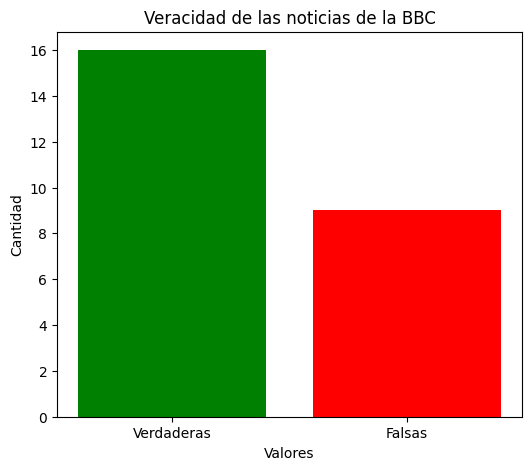

In [33]:
plt.figure(figsize=(6, 5))
plt.bar(['Verdaderas', 'Falsas'], [num_unos, num_ceros], color=['green', 'red'])
plt.title('Veracidad de las noticias de la BBC')
plt.xlabel('Valores')
plt.ylabel('Cantidad')
plt.show()

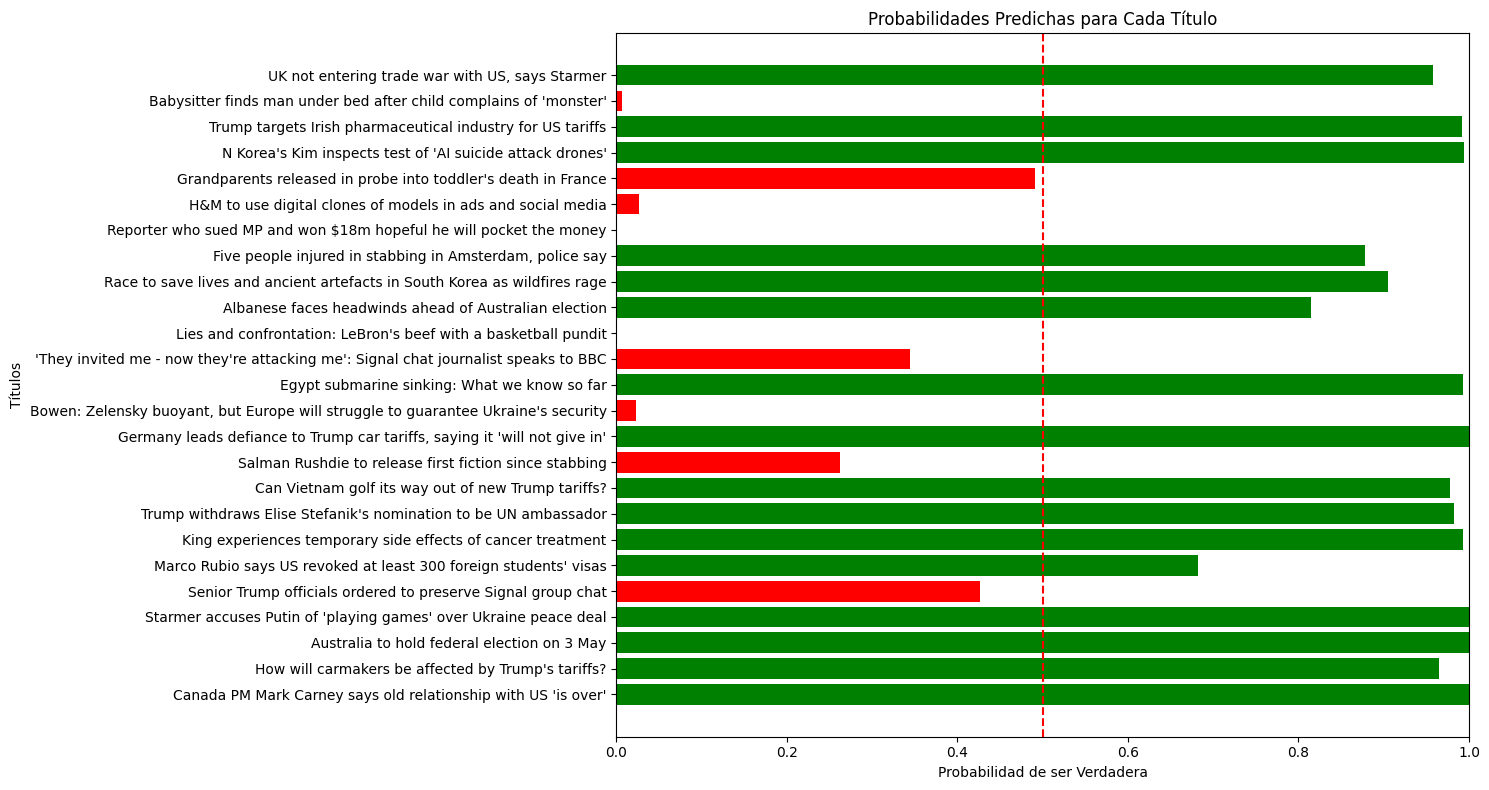

In [36]:
plt.figure(figsize=(15, 8))
plt.barh(df['Titulo'].values, probs_positive_class, color=colors)
plt.xlabel('Probabilidad de ser Verdadera')
plt.ylabel('Títulos')
plt.title('Probabilidades Predichas para Cada Título')
plt.axvline(x=0.5, color='red', linestyle='--')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

In [38]:
etiquetas_veracidad_count = df.explode('Etiquetas').groupby(['Etiquetas', 'Veracidad']).size().unstack(fill_value=0)

In [39]:
etiquetas_veracidad_count

Veracidad,Falsa,Verdadera
Etiquetas,,
Africa,1,0
Amsterdam,0,1
Artificial intelligence,1,0
Australia,0,2
Books,1,0
Canada,0,1
Canada election 2025,0,1
Car industry,0,1
Companies,1,0


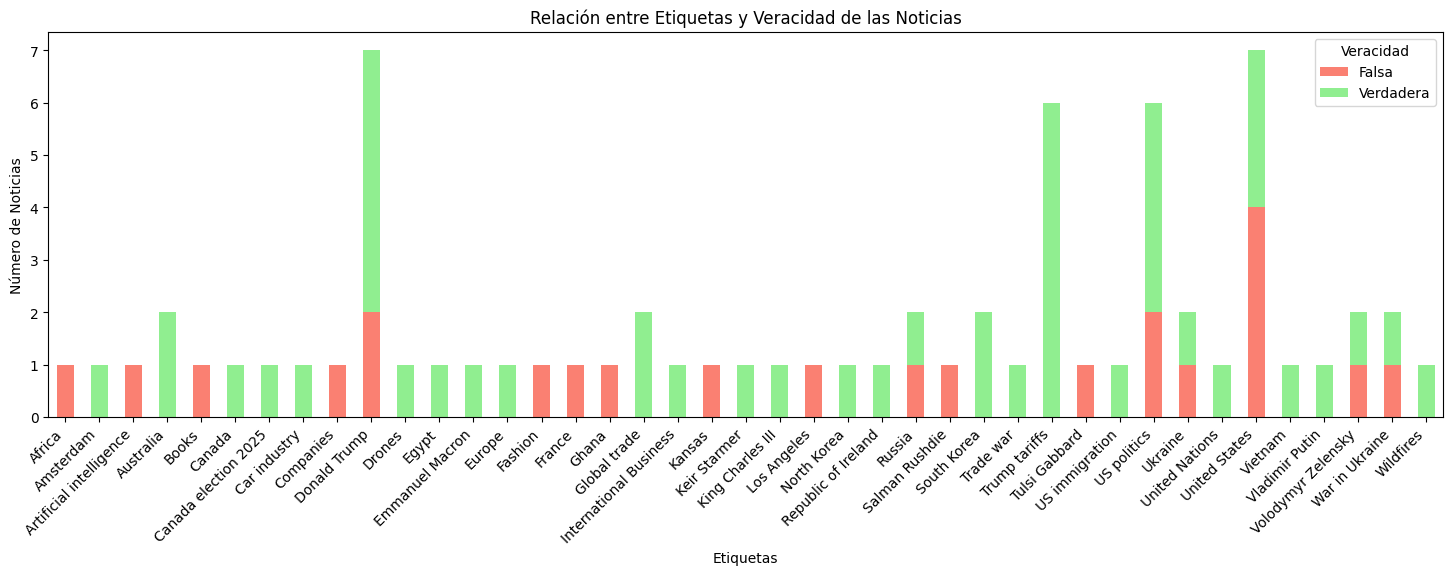

In [40]:
etiquetas_veracidad_count.plot(kind='bar', stacked=True, figsize=(18, 5), color=['salmon', 'lightgreen'])
plt.title('Relación entre Etiquetas y Veracidad de las Noticias')
plt.xlabel('Etiquetas')
plt.ylabel('Número de Noticias')
plt.legend(title='Veracidad', labels=['Falsa', 'Verdadera'])
plt.xticks(rotation=45, ha='right') 
plt.show()

In [73]:
true_news = df[df['Veracidad'] == 'Verdadera']
true_news

,Titulo,Texto,Etiquetas,Contribuyentes,URL,Longitud_Titulo,Longitud_Texto,Veracidad
0,Canada PM Mark Carney says old relationship wi...,Canadian Prime Minister Mark Carney said that ...,"[Trump tariffs, Donald Trump, Canada election ...","[Jessica Murphy , Ali Abbas Ahmadi, Bernd D...",https://www.bbc.com/news/articles/c5y41z4351qo,11,755,Verdadera
1,How will carmakers be affected by Trump's tari...,A day after US President Donald Trump said he ...,"[Trump tariffs, Global trade, Car industry]",[Natalie Sherman],https://www.bbc.com/news/articles/cnvz4097q8ro,8,883,Verdadera
2,Australia to hold federal election on 3 May,Australia will head to the polls for a federal...,[Australia],[Tiffanie Turnbull],https://www.bbc.com/news/articles/cj02033n18go,8,693,Verdadera
3,Starmer accuses Putin of 'playing games' over ...,Western sanctions on Russia need to be increas...,"[War in Ukraine, Volodymyr Zelensky, Keir Star...","[James Gregory , Laura Gozzi]",https://www.bbc.com/news/articles/c78e2x7lz25o,10,870,Verdadera
5,Marco Rubio says US revoked at least 300 forei...,US Secretary of State Marco Rubio said the US ...,"[US immigration, Donald Trump, US politics]",[Madeline Halpert],https://www.bbc.com/news/articles/c75720q9d7lo,11,694,Verdadera
6,King experiences temporary side effects of can...,King Charles III spent a short period of time ...,[King Charles III],"[James Gregory , Sean Coughlan, royal corres...",https://www.bbc.com/news/articles/c3vwgq24klxo,8,598,Verdadera
7,Trump withdraws Elise Stefanik's nomination to...,President Donald Trump has pulled the nominati...,"[United Nations, Donald Trump, US politics]",[Nada Tawfik],https://www.bbc.com/news/articles/c3rnge7ql7wo,9,659,Verdadera
8,Can Vietnam golf its way out of new Trump tari...,Countries around the world are braced for Dona...,"[Vietnam, International Business, Trump tariff...",[Annabelle Liang],https://www.bbc.com/news/articles/cge1r1ezw74o,10,946,Verdadera
10,"Germany leads defiance to Trump car tariffs, s...","Germany has said it ""will not give in"" and tha...","[Trump tariffs, US politics, United States]",[Megan Fisher],https://www.bbc.com/news/articles/cy4vjwzv22eo,13,672,Verdadera
12,Egypt submarine sinking: What we know so far,Six people have died after a tourist submarine...,[Egypt],[Alex Boyd],https://www.bbc.com/news/articles/c1kj9rzmdp9o,8,725,Verdadera


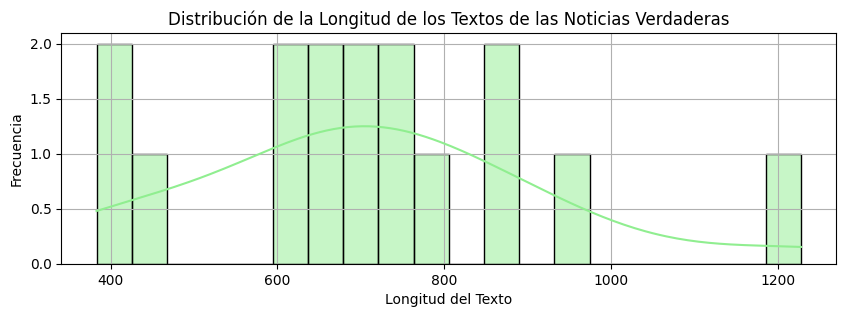

In [76]:
true_news.loc[:, 'longitud_texto'] =true_news['Texto'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 3))
sns.histplot(true_news['longitud_texto'], bins=20, kde=True, color='lightgreen')
plt.title('Distribución de la Longitud de los Textos de las Noticias Verdaderas')
plt.xlabel('Longitud del Texto')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

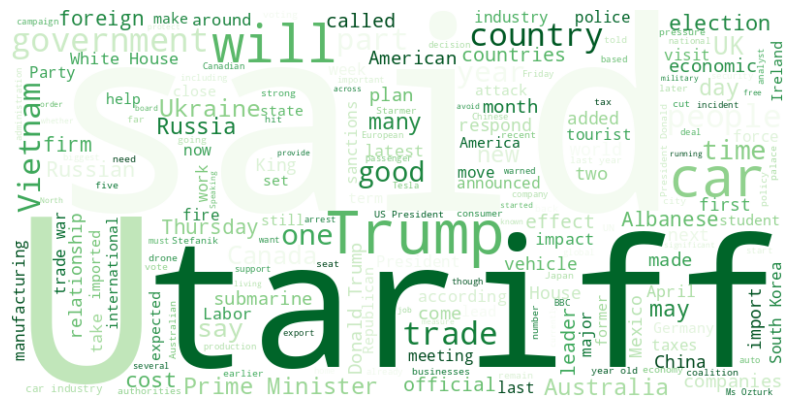

In [81]:
text_true_news = " ".join(true_news['Texto'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(text_true_news)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [59]:
falsas_news = df[df['Veracidad'] == 'Falsa']
falsas_news


,Titulo,Texto,Etiquetas,Contribuyentes,URL,Longitud_Titulo,Longitud_Texto,Veracidad
4,Senior Trump officials ordered to preserve Sig...,A federal judge ordered White House officials ...,"[Donald Trump, Tulsi Gabbard, US politics, Uni...",[Kayla Epstein],https://www.bbc.com/news/articles/c9de770q9e0o,9,653,Falsa
9,Salman Rushdie to release first fiction since ...,Acclaimed author Sir Salman Rushdie is set to ...,"[Salman Rushdie, Books]",[Malu Cursino],https://www.bbc.com/news/articles/c04zw0qvergo,8,501,Falsa
11,"Bowen: Zelensky buoyant, but Europe will strug...",President Volodymyr Zelensky was in a buoyant ...,"[War in Ukraine, Volodymyr Zelensky, Russia, U...",[Jeremy Bowen],https://www.bbc.com/news/articles/c7782kgj8r4o,11,1459,Falsa
13,'They invited me - now they're attacking me': ...,When Jeffrey Goldberg published a bombshell st...,"[Donald Trump, US politics, United States]",[Sarah Smith],https://www.bbc.com/news/articles/c8rk7vyg83xo,14,1190,Falsa
14,Lies and confrontation: LeBron's beef with a b...,"A courtside showdown, verbal swipes and accusa...","[Los Angeles, United States]",[Manish Pandey],https://www.bbc.com/news/articles/c5yr16n5zg8o,9,638,Falsa
18,Reporter who sued MP and won $18m hopeful he w...,An investigative journalist who won an $18m (£...,"[Ghana, Africa]","[Natasha Booty , Daniel Dadzie]",https://www.bbc.com/news/articles/c4gdn4knn7po,13,575,Falsa
19,H&M to use digital clones of models in ads and...,Fashion retailer H&M is to use artificial inte...,"[Companies, Artificial intelligence, Fashion]",[Liv McMahon],https://www.bbc.com/news/articles/c3vwg73xndeo,12,674,Falsa
20,Grandparents released in probe into toddler's ...,The grandparents of Emile Soleil have been rel...,[France],[Laura Gozzi],https://www.bbc.com/news/articles/cddy1q76m66o,9,443,Falsa
23,Babysitter finds man under bed after child com...,A babysitter found a man hiding under a child'...,"[Kansas, United States]",[Mallory Moench],https://www.bbc.com/news/articles/c70e2y98p06o,10,199,Falsa


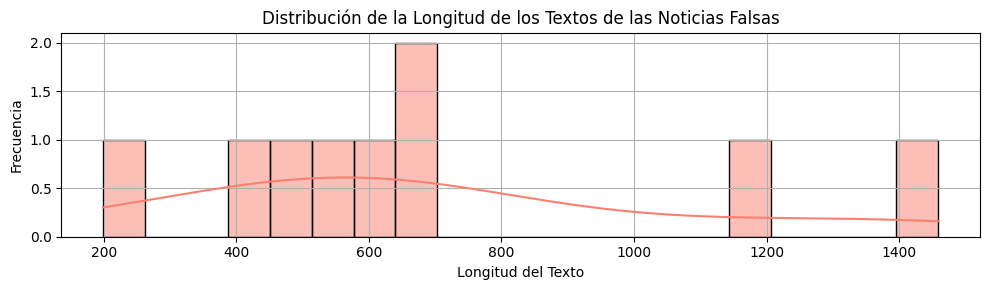

In [70]:
falsas_news.loc[:, 'longitud_texto'] = falsas_news['Texto'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 3))
sns.histplot(falsas_news['longitud_texto'], bins=20, kde=True, color='salmon')
plt.title('Distribución de la Longitud de los Textos de las Noticias Falsas')
plt.xlabel('Longitud del Texto')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

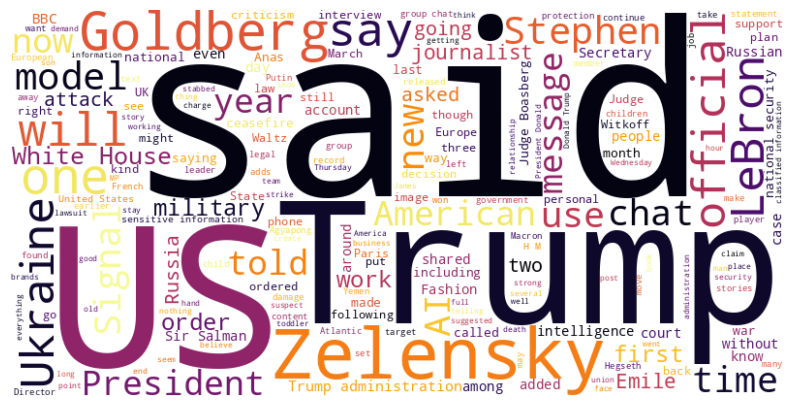

In [83]:
text_falsas = ' '.join(falsas_news['Texto'])

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(text_falsas)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Evaluación

In [43]:
# Suponiendo que todas son verdaderas
true_labels = np.ones(len(probabilities))

In [44]:
accuracy = accuracy_score(true_labels, preds)
print(f"Exactitud (accuracy): {accuracy:.4f}")

Exactitud (accuracy): 0.6400


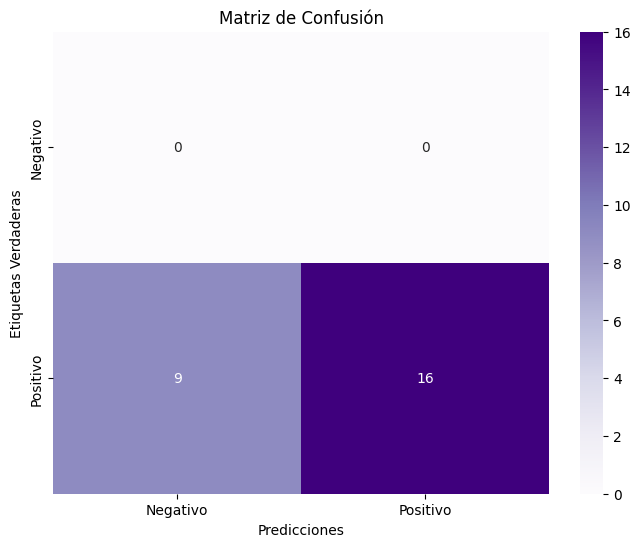

In [49]:
cm = confusion_matrix(true_labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Negativo", "Positivo"], yticklabels=["Negativo", "Positivo"])
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión')
plt.show()